In [16]:
import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt

random.seed(42)

# SYSTEM PARAMETERS

You are free to change these but do not add extra variables here. This entire block will be replaced when marking.

You are free modify the parameters but not the variable names.

In [17]:
# DO NOT ADD OTHER VARIABLE HERE

# General settings
seed = 42
image_file = "sample_map.png"

# Task 1 - Occupancy map
unsafe_kernel_size = 7
unsafe_iterations = 3

# Task 3 - BFS
size_of_node_grid = 10
bfs_start_node = 0
bfs_end_node = 99

# Task 4 - PRM and Dijkstra
iterations = 500
k_connections = 3
max_connection_range = 100
start_location = (100,100)
goal_location = (450,450)

# Task 5 - RRT
goal_radius = 20
step = 40

# DO NOT ADD OTHER VARIABLE HERE

# Task 1 - OCCUPANCY MAP (4 marks total)

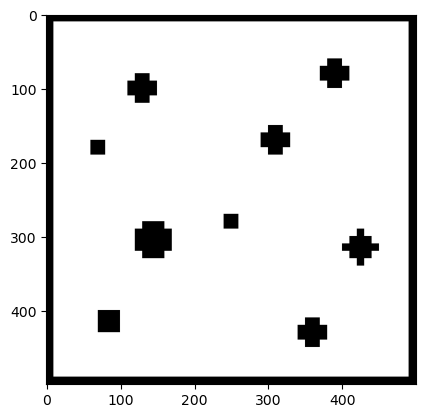

In [18]:
# Task 1.1 (1 mark): Display the occupancy map
image = cv2.imread(image_file)

# Display resulting image
plt.imshow(image)
plt.show()


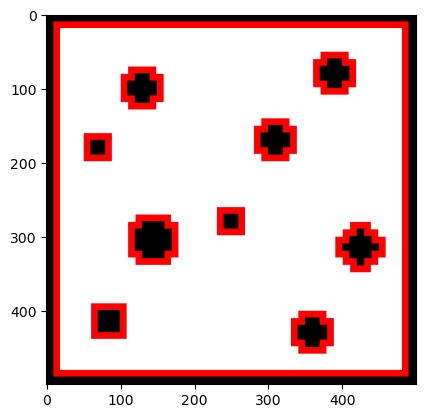

In [19]:
# Task 1.2 (2 Marks): Process occupancy map add and display configuration space
kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
erosion = cv2.erode(gray, kernel, iterations = unsafe_iterations)

mask = (gray != erosion)
mask_erosion = image.copy()
mask_erosion[mask] = [0, 0, 255]

red_outline = cv2.cvtColor(mask_erosion, cv2.COLOR_BGR2RGB)
# Display resulting image
plt.imshow(red_outline)
plt.show()

# Task 2 - Graph Class (3 marks total)

NOTE: This is slightly different to the graph in lab 07. x,y variables have been added to the node object.

In [20]:
# Task 2.1 (3 marks):  Complete the graph class

class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y

    def get_point(self):
        return (self.x, self.y)

    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        newNode = Node(node_id, x, y)
        self.nodes[node_id] = (newNode)

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 not in self.edges:
            self.edges[node_id1] = {}

        if node_id2 not in self.edges:
            self.edges[node_id2] = {}

        self.edges[node_id1][node_id2] = weight
        self.edges[node_id2][node_id1] = weight

    def remove_edge(self, node_id1, node_id2):
        del self.edges[node_id1][node_id2]
        del self.edges[node_id2][node_id1]

    def get_nodes(self):
        return self.nodes

    def get_edge_weight(self, node_id1, node_id2):
        return self.edges[node_id1][node_id2]

    def get_edges(self, node_id):
        if node_id not in self.edges:
            return None

        return self.edges[node_id]

    def has_edge(self, node_id1, node_id2):
        if node_id1 not in self.edges or node_id2 not in self.edges:
            return False

        return node_id2 in self.edges[node_id1]


# Task 3 - BFS (8 marks total)

In [21]:
# This is a useful function which you may choose to impliment and use
# It looks through the image to see if the path is clear between one cooridnate to the next
# Returns True or False
def path_clear(image, x1, y1, x2, y2):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8)
    cv2.line(mask, (x1, y1), (x2, y2), 255, 1)

    line_area = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
    white_pixels = (line_area == [255, 255, 255]).all(axis=2)
    return np.all(white_pixels[mask > 0])


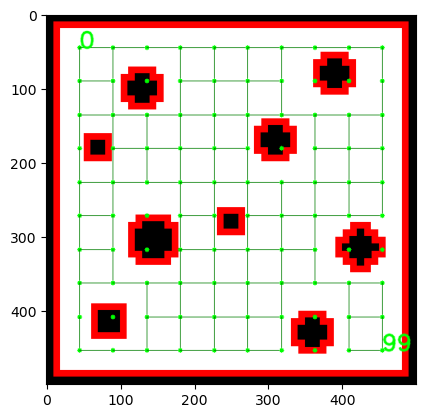

In [22]:
# Task 3.1 (4 marks): Generate a grid of nodes and connect the edges
bfs_image = red_outline.copy()
org_image = red_outline.copy()
bfs_graph = Graph()

height, width, channels = red_outline.shape
y_length = height / (size_of_node_grid + 1)
x_length = width / (size_of_node_grid + 1)

for x in range(size_of_node_grid):
	for y in range(size_of_node_grid):
		node_id = size_of_node_grid * y + x

		pix_y1 = int(y_length * (y + 1))
		pix_x1 = int(x_length * (x + 1))

		# Add node to graph and draw in result image
		bfs_graph.add_node(node_id, x, y)
		cv2.circle(bfs_image,(pix_x1, pix_y1), 3, (0, 255, 0), -1)

		down_coord = y + 1
		right_coord = x + 1
		pix_y2 = int(y_length * (down_coord + 1))
		pix_x2 = int(x_length * (right_coord + 1))
		down_node = size_of_node_grid * down_coord + x
		right_node = size_of_node_grid * y + right_coord

		# Check if nodes from below and to the right are clear and add them to graph and final image
		# Uses original image to check for clearance
		if down_coord < size_of_node_grid and path_clear(org_image, pix_x1, pix_y1, pix_x1, pix_y2):
			bfs_graph.add_edge(node_id, down_node, 1)
			cv2.line(bfs_image,(pix_x1,pix_y1),(pix_x1,pix_y2),(0,125,0),1)

		if right_coord < size_of_node_grid and path_clear(org_image, pix_x1, pix_y1, pix_x2, pix_y1):
			bfs_graph.add_edge(node_id, right_node, 1)
			cv2.line(bfs_image,(pix_x1,pix_y1),(pix_x2,pix_y1),(0,125,0),1)

		# If the current node is the first or last, label the appropriate node
		font = cv2.FONT_HERSHEY_SIMPLEX
		if node_id == 0:
			cv2.putText(bfs_image,str(bfs_start_node),(pix_x1,pix_y1),font,1,(0,255,0),2,cv2.LINE_AA)
		elif node_id == size_of_node_grid * size_of_node_grid - 1:
			cv2.putText(bfs_image,str(bfs_end_node),(pix_x1,pix_y1),font,1,(0,255,0),2,cv2.LINE_AA)


# Display Resulting Image
plt.imshow(bfs_image)
plt.show()


In [23]:
# Task 3.2 (4 marks): Impliment BFS

# Returns an array of nodes in order of which nodes is visited next.
# ie. [0, 10, 20, 30, 40, 50, 60, 70, 71, 72, 73, 74, 75, 76, 77, 78, 88, 98, 99]
def bfs(graph, start_node_id, end_node_id):
    queue = []
    queue.append(start_node_id)

    visited = []
    visited.append(start_node_id)

    parent = {start_node_id: -1}

    curr_node_id = -1
    while len(queue) != 0:
        curr_node_id = queue.pop(0)

        if curr_node_id == end_node_id:
            return reconstruct_path(parent, start_node_id, end_node_id)

        for neighbour in graph.get_edges(curr_node_id):
            if neighbour not in visited:
                visited.append(neighbour)
                parent[neighbour] = curr_node_id
                queue.append(neighbour)

    return []

def reconstruct_path(parent, start, end):
    path = []
    curr_node = end

    while curr_node != parent[start]:
        path.append(curr_node)
        curr_node = parent[curr_node]

    path.reverse()
    return path

Path: [0, 10, 20, 30, 40, 50, 60, 70, 71, 72, 73, 74, 75, 76, 77, 78, 88, 98, 99]


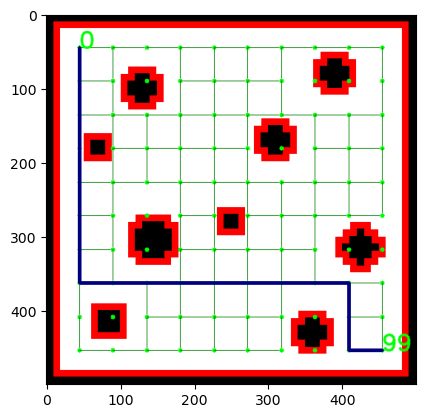

In [24]:
# Task 3.2: Impliment BFS continued
def draw_path(graph, image, path):
    height, width, channels = image.shape
    y_length = height / (size_of_node_grid + 1)
    x_length = width / (size_of_node_grid + 1)

    prev_node_id = path[0]
    for node_id in path:
        if (node_id == path[0]):
            continue

        prev_node = graph.get_nodes()[prev_node_id]
        curr_node = graph.get_nodes()[node_id]

        x1 = prev_node.get_point()[0]
        y1 = prev_node.get_point()[1]
        x2 = curr_node.get_point()[0]
        y2 = curr_node.get_point()[1]

        pix_y1 = int(y_length * (y1 + 1))
        pix_x1 = int(x_length * (x1 + 1))
        pix_y2 = int(y_length * (y2 + 1))
        pix_x2 = int(x_length * (x2 + 1))

        prev_node_id = node_id

        cv2.line(image,(pix_x1,pix_y1),(pix_x2,pix_y2),(0,0,125),3)
    return image

# Run bfs and display the output
path = bfs(bfs_graph,bfs_start_node,bfs_end_node)
bfs_image = draw_path(bfs_graph, bfs_image, path)

# Display resulting image
print(f"Path: {path}")
plt.imshow(bfs_image)
plt.show()

# Task 4 -  PRM and Dijkstra Algorithm (6 marks total)

In [25]:
# This is a useful function which you may choose to impliment and use
# It finds and returns the n closest nodes which are within the range
def find_closest_nodes(image, graph, target_x, target_y, n, range):
    distances = {}
    for node_id in graph.get_nodes():

        node = graph.get_nodes()[node_id]
        x, y = node.get_point()
        if x == target_x and y == target_y:
            continue

        distance = math.sqrt((target_x - x)**2 + (target_y - y)**2)
        if (distance <= range):
            if path_clear(image, target_x, target_y, x, y):
                distances[node_id] = distance

    sorted_dist = dict(sorted(distances.items(), key=lambda item: item[1]))
    sorted_nodes = list(sorted_dist.keys())

    if len(sorted_nodes) < n:
        n = len(sorted_nodes)

    return sorted_nodes[:n]


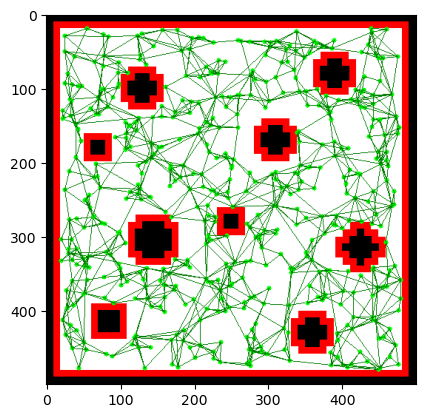

In [26]:
# Task 4.1 (3 marks): PRM
# NOTE: The iteration only increases when a valid node is placed on the map. If the node is invalid, the program should continue without incrementing the iteration count.

prm_image = cv2.imread(image_file)
prm_graph = Graph()
random.seed(seed)

kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
erosion = cv2.erode(gray, kernel, iterations = unsafe_iterations)

mask = (gray != erosion)
mask_erosion = image.copy()
mask_erosion[mask] = [0, 0, 255]

prm_image = cv2.cvtColor(mask_erosion, cv2.COLOR_BGR2RGB)
org_image = prm_image.copy()

i = 0

while i < iterations:
    y1 = random.randint(0, prm_image.shape[0]-1)
    x1 = random.randint(0, prm_image.shape[1]-1)

    pixel_value = org_image[y1, x1]
    if np.all(pixel_value == [255, 255, 255]):
        prm_graph.add_node(i, x1, y1)
        cv2.circle(prm_image,(x1, y1), 3, (0, 255, 0), -1)

        edge_list = find_closest_nodes(org_image, prm_graph, x1, y1, k_connections, max_connection_range)
        for edge_node in edge_list:
            x2, y2 = prm_graph.get_nodes()[edge_node].get_point()
            weight = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

            prm_graph.add_edge(i, edge_node, weight)
            cv2.line(prm_image,(x1,y1),(x2,y2),(0,125,0),1)

        i += 1

# Display resulting image
plt.imshow(prm_image)
plt.show()

In [27]:
# Task 4.2 (3 marks): Dijkstras
# Example output - Path: [-1, 143, 43, 1, 14, 44, 67, 7, 9, 4, 12, 364, -2], Cost: 561.9189671797234
def create_dist_lookup(distances):
    def get_dist(node_id):
        return distances[node_id]

    return get_dist

def dijkstra(graph, start_id, end_id):
    queue = []
    queue.append(start_id)

    visited = []

    dist_to_start = {}
    parent = {start_id: -3}

    for node_id in graph.get_nodes():
        dist_to_start[node_id] = float('inf')

    dist_to_start[start_id] = 0

    while len(queue) != 0:
        curr_node_id = queue.pop(0)

        if curr_node_id in visited:
            continue

        visited.append(curr_node_id)
        for adj_node_id in graph.get_edges(curr_node_id):
            if adj_node_id in visited:
                continue

            alt_dist = dist_to_start[curr_node_id] + graph.get_edge_weight(curr_node_id, adj_node_id)
            if alt_dist < dist_to_start[adj_node_id]:
                dist_to_start[adj_node_id] = alt_dist
                parent[adj_node_id] = curr_node_id
                queue.append(adj_node_id)
                dist_lookup = create_dist_lookup(dist_to_start)
                queue = sorted(queue, key=dist_lookup)

    path = reconstruct_path(parent, start_id, end_id)
    total_cost = dist_to_start[end_id]

    return (path, total_cost)

Path: [-1, 330, 43, 1, 14, 44, 67, 7, 9, 4, 12, 364, -2], Cost: 558.284925664815


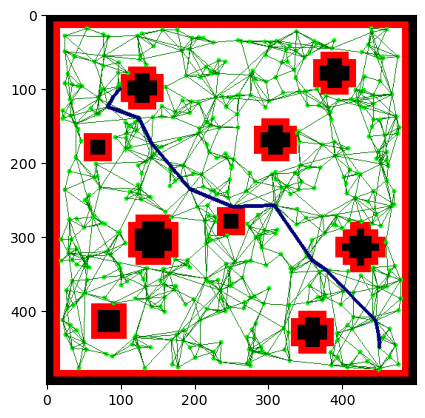

In [28]:
# Task 4.2: Djistraks continued
def draw_path_prm(graph, image, path):
    prev_node_id = path[0]
    for node_id in path:
        if (node_id == path[0]):
            continue

        prev_node = graph.get_nodes()[prev_node_id]
        curr_node = graph.get_nodes()[node_id]

        x1 = prev_node.get_point()[0]
        y1 = prev_node.get_point()[1]
        x2 = curr_node.get_point()[0]
        y2 = curr_node.get_point()[1]

        prev_node_id = node_id

        cv2.line(image,(x1,y1),(x2,y2),(0,0,125),3)

    return image
# Add start (node id = -1) and end (node_id = -2 ) nodes
start_node = -1
goal_node = -2
prm_graph.add_node(start_node, start_location[0], start_location[1])
prm_graph.add_node(goal_node, goal_location[0], goal_location[1])

start_x = start_location[0]
start_y = start_location[1]
goal_x = goal_location[0]
goal_y = goal_location[1]

cv2.circle(prm_image,(start_x, start_y), 3, (0, 255, 0), -1)
cv2.circle(prm_image,(goal_x, goal_y), 3, (0, 255, 0), -1)

x1, y1 = start_location
edge_list = find_closest_nodes(org_image, prm_graph, x1, y1, k_connections, max_connection_range)

for edge_node in edge_list:
    x2, y2 = prm_graph.get_nodes()[edge_node].get_point()
    weight = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    prm_graph.add_edge(start_node, edge_node, weight)
    cv2.line(prm_image,(x1,y1),(x2,y2),(0,125,0),1)

x1, y1 = goal_location
edge_list = find_closest_nodes(org_image, prm_graph, x1, y1, k_connections, max_connection_range)

for edge_node in edge_list:
    x2, y2 = prm_graph.get_nodes()[edge_node].get_point()
    weight = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    prm_graph.add_edge(goal_node, edge_node, weight)
    cv2.line(prm_image,(x1,y1),(x2,y2),(0,125,0),1)

path, cost = dijkstra(prm_graph, start_node, goal_node)

# Display resulting image
prm_image = draw_path_prm(prm_graph, prm_image, path)
print(f"Path: {path}, Cost: {cost}")
plt.imshow(prm_image)
plt.show()


# Task 5 - Rapidly-exploring random trees (RRT) (4 marks total)

In [29]:
# This is a useful function which you may choose to impliment and use
# Given a random point it extends the tree by either the step distance or the cartesian distance
def calculate_new_tree_point(x_closest, y_closest, org_x, org_y,step):
    scale = step / math.sqrt((x_closest - org_x)**2 + (y_closest - org_y)**2)

    new_x = int((org_x - x_closest) * scale + x_closest)
    new_y = int((org_y - y_closest) * scale + y_closest)
    distance = math.sqrt((x_closest - new_x)**2 + (y_closest - new_y)**2)

    return new_x, new_y, distance


# This is a useful function which you may choose to impliment and use
# It finds and returns the closest node to a point on the image
def find_closest_node_rrt(graph, target_x, target_y):
    distances = {}
    for node_id in graph.get_nodes():

        node = graph.get_nodes()[node_id]
        x, y = node.get_point()

        distance = math.sqrt((target_x - x)**2 + (target_y - y)**2)
        distances[node_id] = distance

    sorted_dist = dict(sorted(distances.items(), key=lambda item: item[1]))
    sorted_nodes = list(sorted_dist.keys())

    return sorted_nodes[0]

def find_neighbours(graph, new_node_id, rewire_radius):
    new_node = graph.get_nodes()[new_node_id]
    x0, y0 = new_node.get_point()
    neighbours = []
    for node_id in graph.get_nodes():
        if node_id == new_node_id:
            continue

        node = graph.get_nodes()[node_id]
        x1, y1 = node.get_point()
        distance = math.sqrt((x0 - x1)**2 + (y0 - y1)**2)

        if distance < rewire_radius:
            neighbours.append(node_id)

    return neighbours

def calculate_curr_cost(graph, parent, start_id, target_id):
    cost = 0
    while target_id != start_id:
        cost += graph.get_edge_weight(target_id, parent[target_id])
        target_id = parent[target_id]

    return cost

def find_best_parent(graph, image, parent, start_id, target_id, neighbours):
    target_node = graph.get_nodes()[target_id]
    target_x, target_y = target_node.get_point()

    costs = {}
    for near_id in neighbours:
        near_node = graph.get_nodes()[near_id]
        near_x, near_y = near_node.get_point()
        if path_clear(image, target_x, target_y, near_x, near_y):
            cost = math.sqrt((target_x - near_x)**2 + (target_y - near_y)**2) + calculate_curr_cost(graph, parent, start_id, near_id)
            costs[near_id] = cost

    sorted_costs = dict(sorted(costs.items(), key=lambda item: item[1]))
    sorted_nodes = list(sorted_costs.keys())

    return sorted_nodes[0]

def check_within_goal(x, y, goal_x, goal_y, goal_radius):
    distance = math.sqrt((goal_x - x)**2 + (goal_y - y)**2)
    return distance < goal_radius

def draw_tree(graph, image, start_id, parent):
    for node_id in graph.get_nodes():
        if node_id == start_id:
            continue
        node = graph.get_nodes()[node_id]
        node_x, node_y = node.get_point()
        parent_node = graph.get_nodes()[parent[node_id]]
        parent_x, parent_y = parent_node.get_point()
        cv2.line(image,(node_x,node_y),(parent_x,parent_y),(0,125,0),1)
    return image

Final node:  73 Total Cost:  537.6180357614171


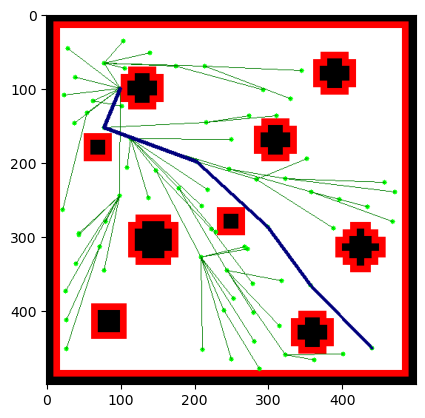

In [30]:
# Task 5.1 (3 marks): RRT/RRT*
# Use the same start and goal locations as PRM

# NOTE: for this implimentation the next iteration is reach only if a valid node is placed
# If, from the source location there is no valid path to the newly placed node. Then the iteration is repeated and a new random x,y location are selected

rrt_image = cv2.imread(image_file)
rrt_graph = Graph()


random.seed(seed)
kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
erosion = cv2.erode(gray, kernel, iterations = unsafe_iterations)

mask = (gray != erosion)
mask_erosion = image.copy()
mask_erosion[mask] = [0, 0, 255]

rrt_image = cv2.cvtColor(mask_erosion, cv2.COLOR_BGR2RGB)
org_image = rrt_image.copy()

# Generate the start node with a node_ID of -1
start_node_id = -1
start_x, start_y = start_location

rrt_graph.add_node(start_node_id, start_x, start_y)

parent = {start_node_id: -2}
beta = 0.2
rewire_radius = 150

new_id = 0
while new_id < iterations:
    init_x, init_y = (0, 0)

    goal_chance = random.random()
    if goal_chance < beta:
        init_x, init_y = goal_location
    else:
        max_y = rrt_image.shape[1]-1
        max_x = rrt_image.shape[0]-1
        init_y = random.randint(0, max_y)
        init_x = random.randint(0, max_x)

    closest_node_id = find_closest_node_rrt(rrt_graph, init_x, init_y)

    closest_node = rrt_graph.get_nodes()[closest_node_id]
    closest_x, closest_y = closest_node.get_point()

    scaled_x, scaled_y, weight = calculate_new_tree_point(closest_x, closest_y, init_x, init_y, step)
    if scaled_x < 0 or scaled_x > max_x or scaled_y < 0 or scaled_y > max_y:
        continue
    pixel_value = org_image[scaled_y, scaled_x]

    if np.all(pixel_value == [255, 255, 255]) and path_clear(org_image, closest_x, closest_y, scaled_x, scaled_y):
        rrt_graph.add_node(new_id, scaled_x, scaled_y)
        cv2.circle(rrt_image,(scaled_x, scaled_y), 3, (0, 255, 0), -1)
        neighbours = find_neighbours(rrt_graph, new_id, rewire_radius)

        best_node_id = find_best_parent(rrt_graph, org_image, parent, start_node_id, new_id, neighbours)
        best_node = rrt_graph.get_nodes()[best_node_id]
        best_x, best_y = best_node.get_point()
        weight = math.sqrt((best_x - scaled_x)**2 + (best_y - scaled_y)**2)
        rrt_graph.add_edge(new_id, best_node_id, weight)
        parent[new_id] = best_node_id

        for near_node_id in neighbours:
            near_node = rrt_graph.get_nodes()[near_node_id]
            near_x, near_y = near_node.get_point()

            if path_clear(org_image, scaled_x, scaled_y, near_x, near_y):
                alt_weight = math.sqrt((near_x - scaled_x)**2 + (near_y - scaled_y)**2)
                near_curr_cost = calculate_curr_cost(rrt_graph, parent, start_node_id, near_node_id)
                new_curr_cost = calculate_curr_cost(rrt_graph, parent, start_node_id, new_id)
                if new_curr_cost + alt_weight < near_curr_cost:
                    rrt_graph.remove_edge(near_node_id, parent[near_node_id])
                    rrt_graph.add_edge(near_node_id, new_id, alt_weight)
                    parent[near_node_id] = new_id

        if check_within_goal(scaled_x, scaled_y, goal_location[0], goal_location[1], goal_radius):
            #cv2.circle(rrt_image,goal_location, goal_radius, (255, 255, 0), -1)
            cv2.circle(rrt_image,(scaled_x, scaled_y), 3, (0, 255, 0), -1)
            rrt_image = draw_tree(rrt_graph, rrt_image, start_node_id, parent)
            path = reconstruct_path(parent, start_node_id, new_id)
            cost = calculate_curr_cost(rrt_graph, parent, start_node_id, new_id)
            print("Final node: ", new_id, "Total Cost: ", cost)
            rrt_image = draw_path_prm(rrt_graph, rrt_image, path)
            break

        new_id += 1

# Display resulting image
plt.imshow(rrt_image)
plt.show()


#### Task 5.2 (1 mark) - Provide a paragraph about informed RRT, discuss the advantages proposed in the paper.

RRT* when given enough time and samples will find the most optimal path. Informed RRT* will find the same optimal path but much quicker, as it isolates its search closer towards the goal. It does this by isolating its search within a shrinking eclipse only after its already established a valid path to the goal. The eclipse focal points are assigned to the goal and the start node. The maximum diameter must encompass the current lowest cost solution. The eclipse dimensions change (shrink) when a more optimal path is found. To implement this method into the code, there needs to be a helper that only allows nodes to be generated within the eclipse dimensions. Either limit a random generator to be within the eclipse or simply validate that some random point in the map is within the eclipse. Instead of terminating once a goal is found, it must keep iterating to find a more optimal solution.

